<a href="https://colab.research.google.com/github/Pranesh1306/Pranesh1306/blob/main/optic_disc_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [2]:
def preprocess_image(image_path, target_size):
    image = cv2.imread(image_path, 0)  # Load image in grayscale
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_NEAREST)
    image = image / 255.0  # Normalize by dividing by 255
    return image

def preprocess_label(label_path, target_size):
    label = cv2.imread(label_path, 0)  # Load label in grayscale
    label = cv2.resize(label, target_size, interpolation=cv2.INTER_NEAREST)
    label = label / 255.0  # Normalize by dividing by 255
    return label

import os
from PIL import Image

def preprocess_data(image_folder, label_folder, target_size):
    image_files = sorted(os.listdir(image_folder))
    label_files = sorted(os.listdir(label_folder))

    # Check if the number of image and label files match
    if len(image_files) != len(label_files):
      print("Number of image files and label files do not match.")
    else:
    # Check if the file names are correctly matched
      for image_file, label_file in zip(image_files, label_files):
          image_name = os.path.splitext(image_file)[0]
          label_name = os.path.splitext(label_file)[0]
          if image_name != label_name:
              print(f"Image file '{image_file}' and label file '{label_file}' do not have matching names.")

    images = []
    labels = []

    image_files = os.listdir(image_folder)
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, image_file)

        image = preprocess_image(image_path, target_size)
        label = preprocess_image(label_path, target_size)

        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [3]:
# Paths to the image and label folders
import zipfile
zip_file_path_1 = "/content/images.zip"
zip_file_path_2 = "/content/labels.zip"

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path_1, 'r') as zip_ref:
    zip_ref.extractall('images')  # Extract to the 'images' directory
# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path_2, 'r') as zip_ref:
    zip_ref.extractall('labels')  # Extract to the 'images' directory


In [4]:
image_folder = "/content/images"
label_folder = "/content/labels"

In [5]:
# Preprocess the data
target_size = (256, 256)
images, labels = preprocess_data(image_folder,label_folder, target_size)

In [6]:
print(np.shape(images))
print(np.shape(labels))

(220, 256, 256)
(220, 256, 256)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3
)

# Convert the tuples to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Reshape the images and labels to match the expected input shape
reshaped_images = images.reshape(-1, target_size[0], target_size[1], 1)
reshaped_labels = labels.reshape(-1, target_size[0], target_size[1], 1)

# Combine images and labels
combined = np.concatenate([reshaped_images, reshaped_labels], axis=-1)

# Generate augmented images
augmented = []
for image in combined:
    augmented.extend(datagen.flow(np.expand_dims(image, axis=0), batch_size=1)[0])

# Convert the augmented images back to numpy array format
augmented = np.array(augmented)

# Split the augmented images and labels
augmented_images = augmented[..., :1]
augmented_labels = augmented[..., 1:]



/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 256, 256, 2) (2 channels).
  warnings.warn(


In [8]:
print("Shape of augmented_images:", augmented_images.shape)
print("Shape of augmented_labels:", augmented_labels.shape)
print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)

Shape of augmented_images: (220, 256, 256, 1)
Shape of augmented_labels: (220, 256, 256, 1)
Shape of images: (220, 256, 256)
Shape of labels: (220, 256, 256)


In [9]:
images = images[:, :, :, np.newaxis]
labels = labels[:, :, :, np.newaxis]
# Concatenate images
concatenated_images = np.concatenate((augmented_images, images), axis=0)

# Concatenate labels
concatenated_labels = np.concatenate((augmented_labels, labels), axis=0)

In [10]:
train_images, test_images, train_labels, test_labels = train_test_split(concatenated_images,concatenated_labels, test_size=0.2,
random_state=42)

In [11]:
np.shape(train_images)

(352, 256, 256, 1)

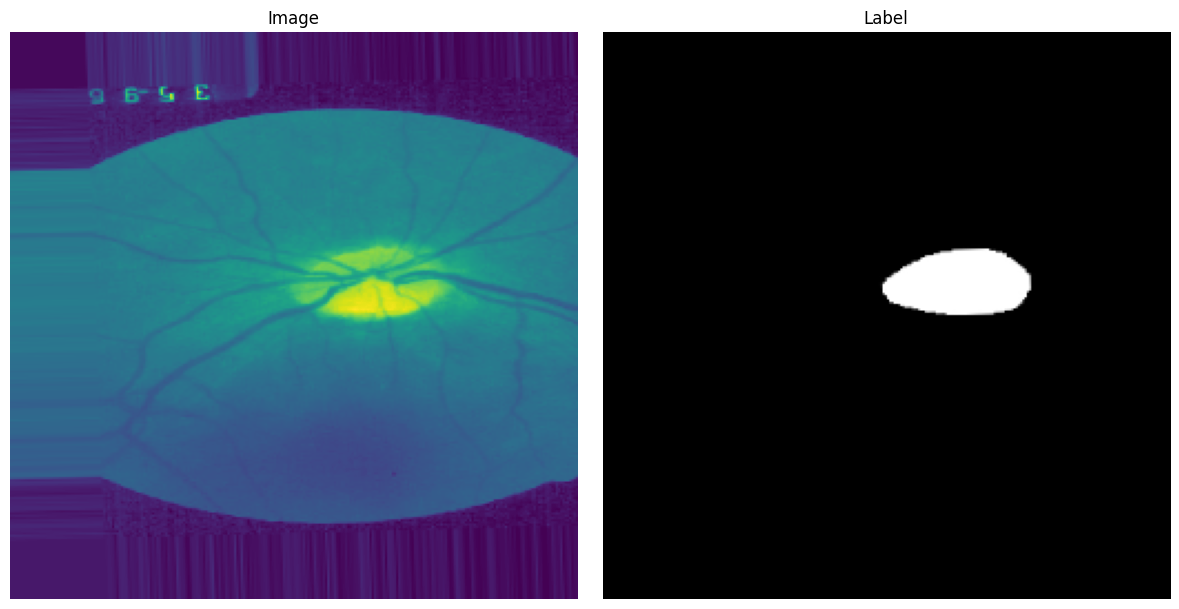

In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Select a random image index
image_number = random.randint(0, len(augmented_images) - 1)

# Plot the selected image and its label
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(augmented_images[image_number])
plt.title("Image")
plt.axis("off")

plt.subplot(122)
plt.imshow(augmented_labels[image_number].squeeze(), cmap='gray')
plt.title("Label")
plt.axis("off")

plt.tight_layout()
plt.show()


In [13]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    from keras import backend as K

    def iou(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

    def accuracy(y_true, y_pred):
        return K.mean(K.equal(y_true, K.round(y_pred)), axis=-1)

    def sensitivity(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())

    def specificity(y_true, y_pred):
        true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
        return true_negatives / (possible_negatives + K.epsilon())

    model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=[accuracy, sensitivity, specificity, iou])

    model.summary()

    return model


In [14]:
IMG_HEIGHT = concatenated_images.shape[1]
IMG_WIDTH  = concatenated_images.shape[2]
IMG_CHANNELS = concatenated_images.shape[3]

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()


#If starting with pre-trained weights.
#model.load_weights('mitochondria_gpu_tf1.4.hdf5')

history = model.fit(train_images, train_labels,
                    batch_size = 8,
                    verbose=1,
                    epochs=50,
                    validation_data=(test_images, test_labels),
                    shuffle=False)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

3/3 [==============================] - 0s 87ms/step


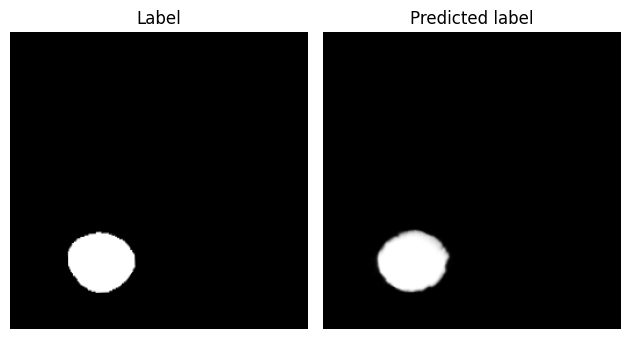

In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on the test images
predicted_labels = model.predict(test_images)

# Select a random image index
image_number = random.randint(0, len(test_images) - 1)

# Plot the selected image and its label
plt.subplot(121)
plt.imshow(test_labels[image_number].squeeze(), cmap='gray')
plt.title("Label")
plt.axis("off")

plt.subplot(122)
plt.imshow(predicted_labels[image_number].squeeze(), cmap='gray')
plt.title("Predicted label")
plt.axis("off")

plt.tight_layout()
plt.show()

In [19]:
import numpy as np

def calculate_iou(y_true, y_pred):
    # Flatten the input arrays to 1D to make the calculation easier
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Calculate true positive (intersection)
    intersection = np.sum(y_true * y_pred)

    # Calculate the sum of true positive, false positive and false negative (union)
    union = np.sum(y_true) + np.sum(y_pred) - intersection

    # Avoid division by zero
    if union == 0:
        return 1.0

    # Return IoU
    return intersection / union

def calculate_mean_iou(y_trues, y_preds):
    ious = [calculate_iou(y_true, y_pred) for y_true, y_pred in zip(y_trues, y_preds)]
    return np.mean(ious)


In [18]:
mean_iou = calculate_mean_iou(test_labels, predicted_labels)
print("MeanIOU:", mean_iou)

MeanIOU: 0.8437266654125289
